# EDA v2 - Control vs Test set

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import ks_2samp

In [2]:
path = "../data"

In [3]:
lalonde_exp = pd.read_csv(f"{path}/lalonde_exp.csv")

## Univariate Analysis

### Age

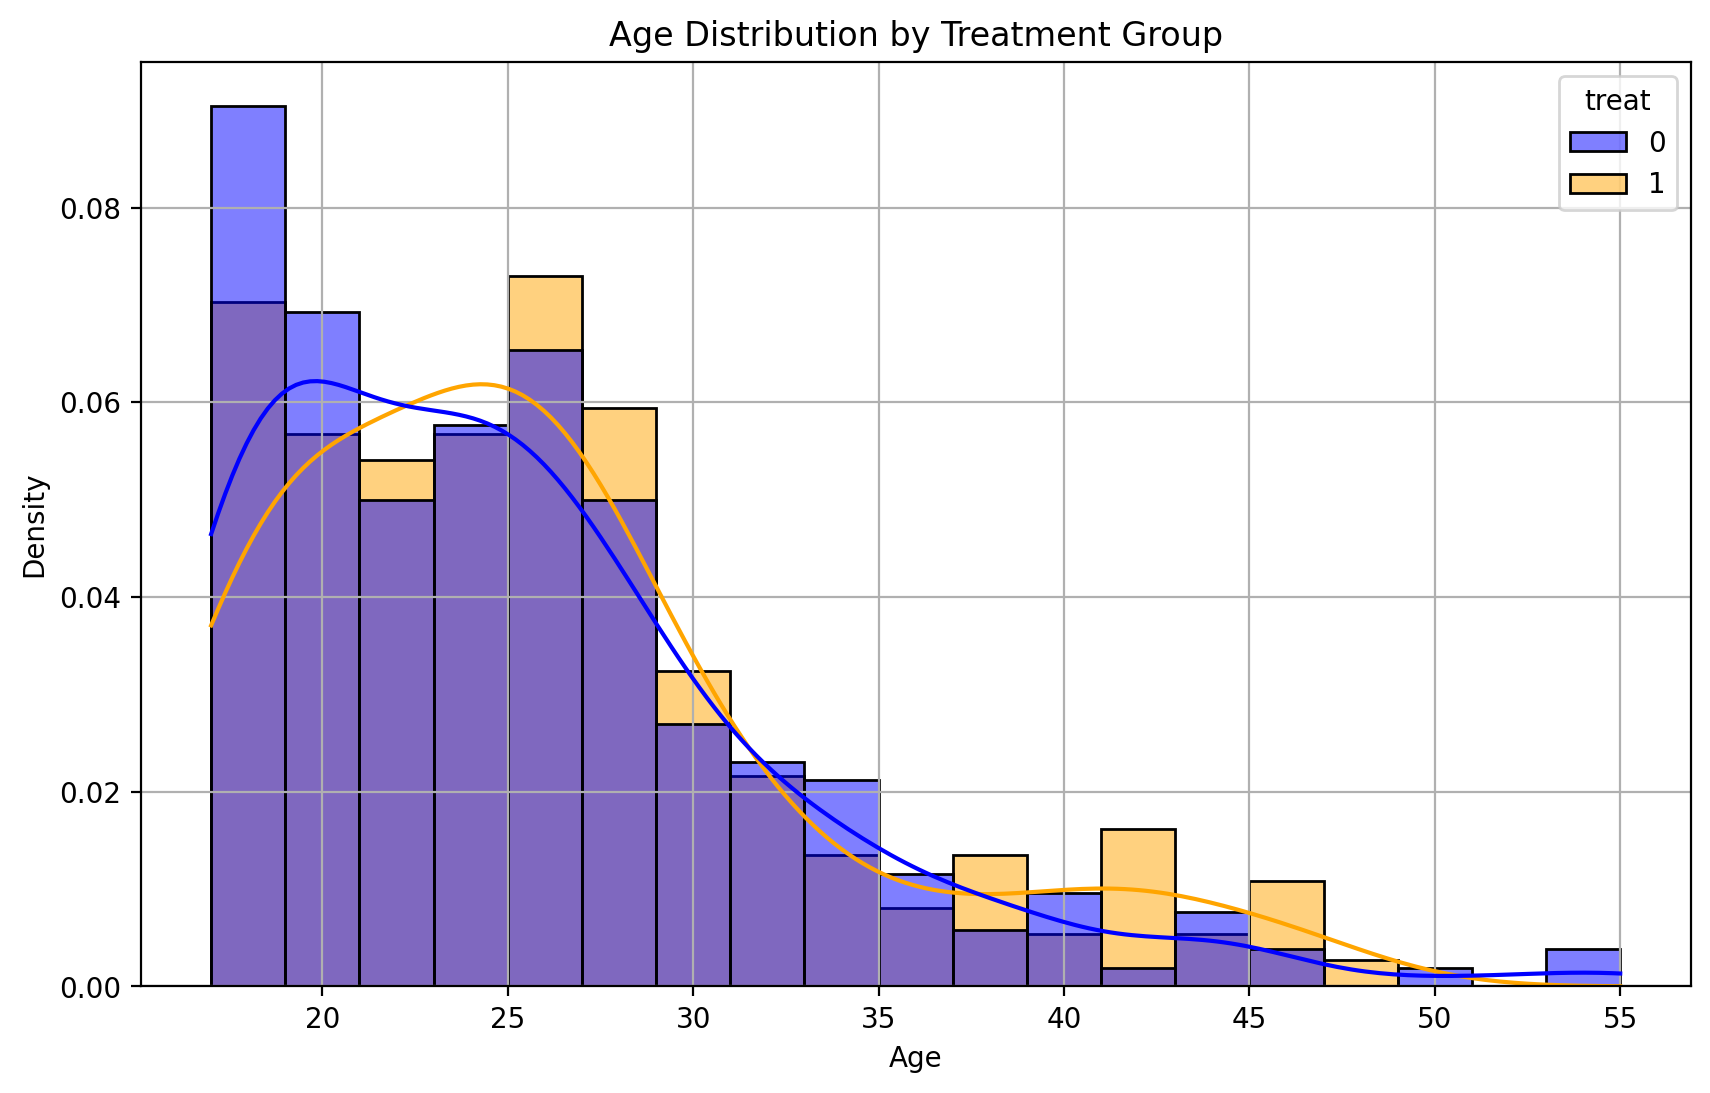

In [4]:
plt.figure(figsize=(10, 6), dpi=200)

sns.histplot(
    data=lalonde_exp,
    x="age",
    hue="treat",
    kde=True,
    stat="density",
    common_norm=False,
    palette=["blue", "orange"],
)

plt.title("Age Distribution by Treatment Group")
plt.xlabel("Age")
plt.ylabel("Density")
plt.grid()
plt.show()

In [5]:
group0 = lalonde_exp[lalonde_exp["treat"] == 0]["age"]
group1 = lalonde_exp[lalonde_exp["treat"] == 1]["age"]

In [6]:
print("Kolmogorov-Smirnov Test Results:", ks_2samp(group0, group1))

Kolmogorov-Smirnov Test Results: KstestResult(statistic=0.06517671517671518, pvalue=0.716234612144968, statistic_location=20, statistic_sign=1)


Thus, based on this p-value, we fail to reject the hypothesis that the age distributions are the same across the two groups. Hence they must be from the same group.

In [7]:
age_bins = [0, 25, 33, 40, float("inf")]
age_labels = ["0-25", "26-33", "34-40", "41+"]

In [8]:
lalonde_exp["age_group"] = pd.cut(
    lalonde_exp["age"],
    bins=age_bins,
    labels=age_labels,
    right=False,
    include_lowest=True,
)

In [9]:
lalonde_exp.groupby(["treat", "age_group"])["id"].count() / lalonde_exp.groupby(
    ["treat"]
)["id"].count()

/var/folders/0b/ny60dqh52qs1n21clwwttn7w0000gn/T/ipykernel_75648/150170892.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  lalonde_exp.groupby(["treat", "age_group"])["id"].count() / lalonde_exp.groupby(


treat  age_group
0      0-25         0.534615
       26-33        0.330769
       34-40        0.096154
       41+          0.038462
1      0-25         0.475676
       26-33        0.372973
       34-40        0.070270
       41+          0.081081
Name: id, dtype: float64

### Education

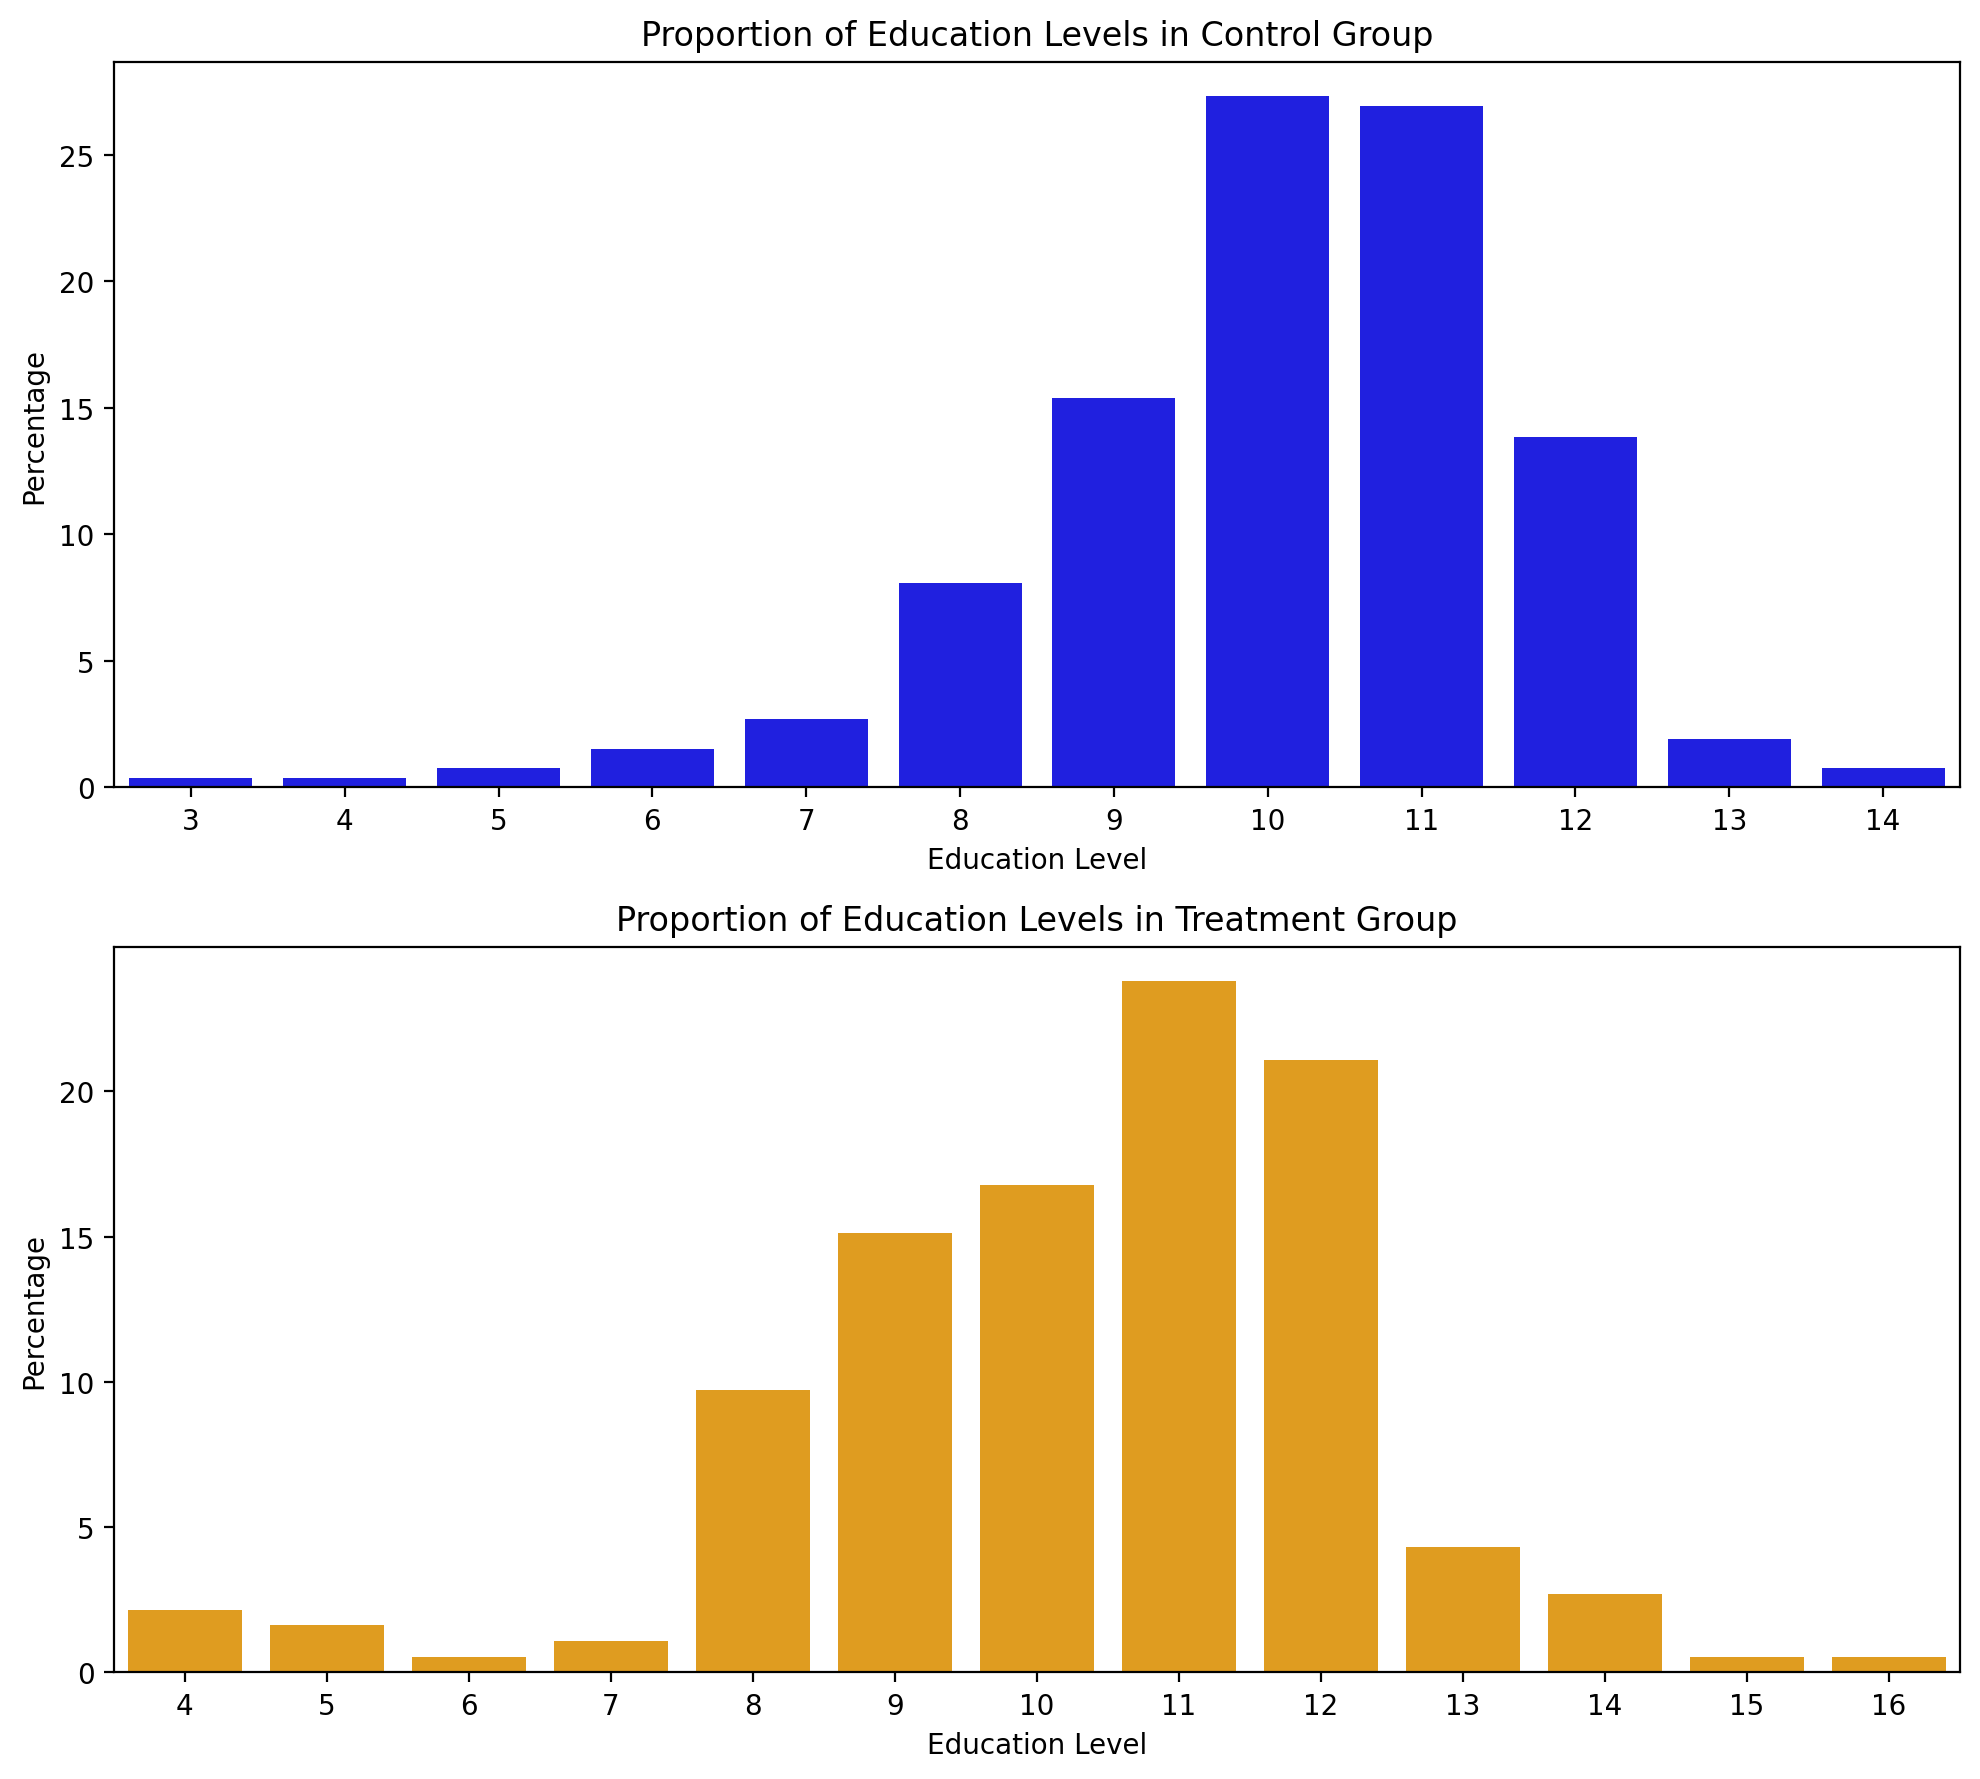

In [10]:
grouped = lalonde_exp.groupby(["treat", "education"]).size().reset_index(name="count")
total = grouped.groupby("treat")["count"].transform("sum")
grouped["percentage"] = (grouped["count"] / total) * 100

fig, axes = plt.subplots(2, 1, figsize=(10, 9), dpi=200)

sns.barplot(
    x="education",
    y="percentage",
    data=grouped[grouped["treat"] == 0],
    ax=axes[0],
    color="blue",
)
axes[0].set_title("Proportion of Education Levels in Control Group")
axes[0].set_xlabel("Education Level")
axes[0].set_ylabel("Percentage")

sns.barplot(
    x="education",
    y="percentage",
    data=grouped[grouped["treat"] == 1],
    ax=axes[1],
    color="orange",
)
axes[1].set_title("Proportion of Education Levels in Treatment Group")
axes[1].set_xlabel("Education Level")
axes[1].set_ylabel("Percentage")

plt.tight_layout()
plt.show()

Education doesn't seem to be equally distributed. Let's look at nodegree.

In [11]:
lalonde_exp.groupby(["treat", "nodegree"])["id"].count() / lalonde_exp.groupby(
    ["treat"]
)["id"].count()

treat  nodegree
0      0           0.165385
       1           0.834615
1      0           0.291892
       1           0.708108
Name: id, dtype: float64

They look similar, but let's assume there's no bias in their selection right now.

In [12]:
bins = [0, 5, 8, 12, float("inf")]
labels = ["0-5", "6-8", "9-12", "13+"]

In [13]:
lalonde_exp["education_group"] = pd.cut(
    lalonde_exp["education"], bins=bins, labels=labels, right=True, include_lowest=True
)

In [14]:
lalonde_exp.groupby(["treat", "education_group"])["id"].count() / lalonde_exp.groupby(
    ["treat"]
)["id"].count()

/var/folders/0b/ny60dqh52qs1n21clwwttn7w0000gn/T/ipykernel_75648/3421541932.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  lalonde_exp.groupby(["treat", "education_group"])["id"].count() / lalonde_exp.groupby(


treat  education_group
0      0-5                0.015385
       6-8                0.123077
       9-12               0.834615
       13+                0.026923
1      0-5                0.037838
       6-8                0.113514
       9-12               0.767568
       13+                0.081081
Name: id, dtype: float64

### Race

In [15]:
lalonde_exp.groupby(["treat", "black"])["id"].count() / lalonde_exp.groupby(["treat"])[
    "id"
].count()

treat  black
0      0        0.173077
       1        0.826923
1      0        0.156757
       1        0.843243
Name: id, dtype: float64

In [16]:
lalonde_exp.groupby(["treat", "hispanic"])["id"].count() / lalonde_exp.groupby(
    ["treat"]
)["id"].count()

treat  hispanic
0      0           0.892308
       1           0.107692
1      0           0.940541
       1           0.059459
Name: id, dtype: float64

### Married

In [17]:
lalonde_exp.groupby(["treat", "married"])["id"].count() / lalonde_exp.groupby(
    ["treat"]
)["id"].count()

treat  married
0      0          0.846154
       1          0.153846
1      0          0.810811
       1          0.189189
Name: id, dtype: float64

## Random assignment

Let's verify to see if the initial revenue is independent of the treatment variable.

In [18]:
lalonde_exp_dummified_df = pd.get_dummies(
    lalonde_exp[
        [
            "married",
            "re74",
            "re75",
            "treat",
            "age",
            "black",
            "hispanic",
            "education",
        ]
    ]
)

In [19]:
X = lalonde_exp_dummified_df.drop("treat", axis=1)
y = lalonde_exp_dummified_df["treat"]

X = sm.add_constant(X)

In [20]:
model = sm.Logit(y, X).fit()

Optimization terminated successfully.
         Current function value: 0.669232
         Iterations 5


In [21]:
print(model.summary())

                           Logit Regression Results                           
Dep. Variable:                  treat   No. Observations:                  445
Model:                          Logit   Df Residuals:                      437
Method:                           MLE   Df Model:                            7
Date:                Sun, 19 May 2024   Pseudo R-squ.:                 0.01421
Time:                        01:41:56   Log-Likelihood:                -297.81
converged:                       True   LL-Null:                       -302.10
Covariance Type:            nonrobust   LLR p-value:                    0.2840
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.9237      0.769     -1.201      0.230      -2.432       0.584
married        0.1440      0.273      0.527      0.598      -0.392       0.680
re74       -2.213e-05   2.52e-05     -0.878      0.3

## ATE

In [22]:
lalonde_exp.groupby(['treat'])['re78'].mean()

treat
0    4554.802283
1    6349.145368
Name: re78, dtype: float64